# Part-1 A Simple Deep learning Pipeline

## Imports

In [135]:
from pathlib import Path
import requests
import pickle
import math
import gzip
import numpy as np
import matplotlib.pyplot as plt
import PIL
#pytorch imports
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F

#Torchvision imports
from torchvision import transforms
import torchvision.datasets as datasets
from torchvision.models.resnet import resnet34

import pdb


In [2]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'mnist'

## Get Data

In [3]:
PATH.mkdir(parents=True, exist_ok=True)

URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'
FILEPATH = (PATH/FILENAME)

In [4]:
if not (FILEPATH).exists():
    content = requests.get(URL+FILENAME).content
    (FILEPATH).open(mode='wb').write(content)

In [5]:
with gzip.open(FILEPATH,mode='rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [6]:
x_train.shape,type(x_train)

((50000, 784), numpy.ndarray)

In [7]:
x = x_train.reshape((-1,28,28))

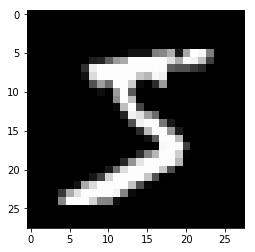

In [8]:
plt.imshow(x[0],cmap='gray')

## Data Pipeline

### Creating Dataset

In [27]:
class MnistDataset(Dataset):
    def __init__(self,x,y,transform=None):
        self.x = x
        self.y = y
        self.transform = transform
    
    def __getitem__(self,idx):
        return self.x[idx].reshape(28,28),self.y[idx]
    
    def __len__(self):
        return len(self.x)

In [28]:
trn_ds = MnistDataset(x_train,y_train)
valid_ds = MnistDataset(x_valid,y_valid)

In [29]:
def get_rand_img_from_ds(ds):
    rand_idx = np.random.randint(0,len(ds))
    img,label = ds[rand_idx]
    return img,label
    
    

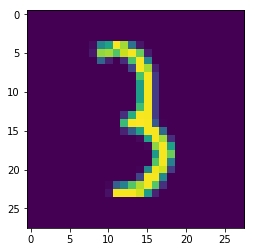

In [30]:
plt.imshow(get_rand_img_from_ds(trn_ds)[0])

In [31]:
def show_imgs_from_ds(ds=None,ds_fn=None,samples=16,figsize=(9,9),axis=False,cmap='gray'):
    rows = int(math.sqrt(samples))
    fig,axs = plt.subplots(rows,rows,figsize=figsize)
    for ax in axs.flatten():
        img,label = ds_fn(ds)
        ax.imshow(img,cmap=cmap)
        if not label is None:ax.set_title(label)
        if not axis:ax.axis('off')
   

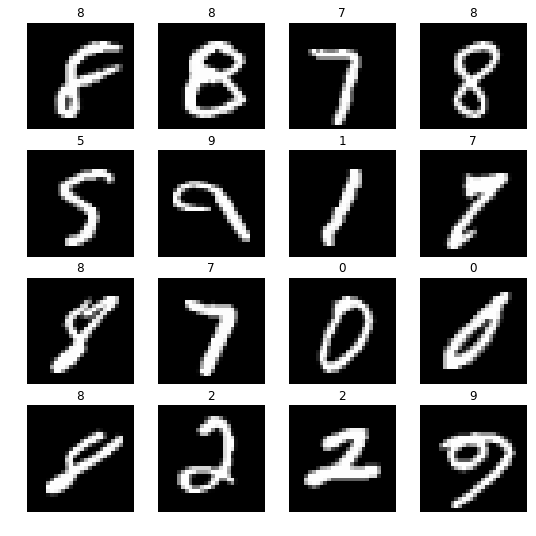

In [32]:
show_imgs_from_ds(trn_ds,get_rand_img_from_ds)

In [33]:
tfms = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])
                             
trn_ds = MnistDataset(x_train,y_train,transform=transforms.Compose(tfms))
val_ds = MnistDataset(x_valid,y_valid,transform=transforms.Compose(tfms))

### Creating Dataloader

In [34]:
trn_dl = DataLoader(dataset=trn_ds,batch_size=32,shuffle=True,num_workers=6)
val_dl = DataLoader(dataset=val_ds,batch_size=32,shuffle=False,num_workers=6)

In [35]:
def denorm (inp,mean,std):
    inp = inp.numpy()
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp
from functools import partial
mnist_denorm = partial(denorm,mean=[0.1307,],std=[0.3081,])

In [36]:
#Fetch a batch of images
xs,ys = next(iter(trn_dl))

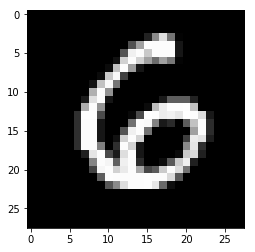

In [37]:
plt.imshow(mnist_denorm(xs)[0],cmap='gray')

## Create a simple CNN

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Train the model

### Move the model to GPU

In [38]:
device = torch.device('cuda')
model = Net().to(device)

### Create optimizer

In [39]:
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

### Train the algorithm

In [25]:
def fit(epochs,model,train_dl,val_dl,device,optim,loss_fn):
    for epoch in range(epochs):
        model.train()
        trn_loss = 0
        for batch_idx,(x,y) in enumerate(trn_dl):
            x,y = x.to(device),y.to(device)
            optim.zero_grad()
            outp = model(x)
            loss = loss_fn(outp,y)
            loss.backward()
            optim.step()
            trn_loss += loss.item()
        
        model.eval()
        val_loss = 0
        correct = 0
        for batch_idx,(x,y) in enumerate(val_dl):
            with torch.no_grad():
                x,y = x.to(device),y.to(device)
                outp = model(x)
                val_loss += loss_fn(outp,y,reduction='sum').item()
                pred = outp.max(dim=1,keepdim=True)[1]
                correct += pred.eq(y.view_as(pred)).sum().item()
        val_loss /= len(val_dl.dataset)

        print(f'Epoch {epoch} || Train loss {trn_loss/len(train_dl):.2f} || Val loss {val_loss:.2f} || Accuracy {100. * correct / len(val_dl.dataset)}')        
                
            
        

In [26]:
fit(4,model,trn_dl,val_dl,device,optimizer,F.nll_loss)

Epoch 0 || Train loss 0.61 || Val loss 0.11 || Accuracy 96.69
Epoch 1 || Train loss 0.28 || Val loss 0.08 || Accuracy 97.8
Epoch 2 || Train loss 0.23 || Val loss 0.07 || Accuracy 98.0
Epoch 3 || Train loss 0.20 || Val loss 0.07 || Accuracy 98.08


# Part-2 Refactor the network and build a modern network architecture inspired ResNet and Squeeze Excitation 

## Refactoring Model , Writing Custom layers, Using Pytorch Sequential API

### Writing Custom layer

In [41]:
class Lambda(nn.Module): 
    def __init__(self,function):
        super().__init__()
        self.function = function
    
    def forward(self,x):
        return self.function(x)  
def Flatten(): return Lambda(lambda x: x.view(x.size(0),-1))
def Reshape(): return Lambda(lambda x:x.view(-1,1,28,28))

### Using Sequential API

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.nn = nn.Sequential(Reshape(),
                                nn.Conv2d(1, 10, kernel_size=5),
                                nn.MaxPool2d(2),
                                nn.ReLU(),
                                nn.Conv2d(10, 20, kernel_size=5),
                                nn.MaxPool2d(2),
                                nn.ReLU(),
                                nn.Dropout2d(),
                                Flatten(),
                                nn.Linear(320, 50),
                                nn.Linear(50, 10),
                                nn.LogSoftmax(dim=1)                            
                                      )
    def forward(self,x):
        return self.nn(x)
                                

### Train model

In [43]:
def get_model(network,device):
    model = network().to(device)
    optimizer = optim.SGD(model.parameters(),lr=1e-2,momentum=0.9)
    return model,optimizer

In [44]:
model,optimizer = get_model(Net,device)

In [45]:
fit(5,model,trn_dl,val_dl,device,optimizer,F.nll_loss)

Epoch 0 || Train loss 0.36 || Val loss 0.09 || Accuracy 97.52
Epoch 1 || Train loss 0.15 || Val loss 0.08 || Accuracy 97.53
Epoch 2 || Train loss 0.12 || Val loss 0.06 || Accuracy 98.3
Epoch 3 || Train loss 0.11 || Val loss 0.05 || Accuracy 98.43
Epoch 4 || Train loss 0.10 || Val loss 0.06 || Accuracy 98.16


## Refactor more + Batch Normalization + Crossentropy Loss

In [88]:
def conv_block(ni,no,ks,max_pool=True,act=True):
    model = nn.Sequential(nn.Conv2d(in_channels=ni,out_channels=no,kernel_size=ks),        
                         nn.BatchNorm2d(num_features=no),
                         )
    if act:model.add_module('relu',nn.ReLU(inplace=True))
    if max_pool : model.add_module('max_pool',nn.MaxPool2d(2)) 
    return model 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.nn = nn.Sequential(Reshape(),
                                conv_block(1,10,5),
                                conv_block(10,20,5),
                                nn.Dropout2d(),
                                Flatten(),
                                nn.Linear(320, 50),
                                nn.Linear(50, 10),
                                      )
    def forward(self,x):
        return self.nn(x)

model,optimizer = get_model(Net,device)
fit(10,model,trn_dl,val_dl,device,optimizer,F.cross_entropy)

Epoch 0 || Train loss 0.28 || Val loss 0.08 || Accuracy 97.68
Epoch 1 || Train loss 0.13 || Val loss 0.07 || Accuracy 98.12
Epoch 2 || Train loss 0.11 || Val loss 0.06 || Accuracy 98.44
Epoch 3 || Train loss 0.09 || Val loss 0.05 || Accuracy 98.28
Epoch 4 || Train loss 0.09 || Val loss 0.05 || Accuracy 98.39
Epoch 5 || Train loss 0.08 || Val loss 0.05 || Accuracy 98.61
Epoch 6 || Train loss 0.08 || Val loss 0.05 || Accuracy 98.52
Epoch 7 || Train loss 0.07 || Val loss 0.04 || Accuracy 98.75
Epoch 8 || Train loss 0.07 || Val loss 0.04 || Accuracy 98.71
Epoch 9 || Train loss 0.07 || Val loss 0.04 || Accuracy 98.77


## Building a mini resnet 

In [89]:
def conv_block(ni,no,ks,max_pool=True,act=True):
    model = nn.Sequential(nn.Conv2d(in_channels=ni,out_channels=no,kernel_size=ks,padding=ks//2),        
                         nn.BatchNorm2d(num_features=no),
                         )
    if act:model.add_module('relu',nn.ReLU(inplace=True))
    if max_pool : model.add_module('max_pool',nn.MaxPool2d(2)) 
    return model 

class ResBlock(nn.Module):
    def __init__(self,ni,no,ks):
        super().__init__()
        self.conv_block = conv_block(ni,no,ks,False,False)
        self.downsample = conv_block(ni,no,ks,False,False) if ni != no else None
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self,x):
        out = self.conv_block(x)
        if self.downsample :
            out += self.downsample(x)
        else :
            out += x
        return self.relu(out)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.nn = nn.Sequential(Lambda(lambda x:x.view(-1,1,28,28)),
                                conv_block(1,16,3),
                                ResBlock(16,16,3),
                                ResBlock(16,32,3),
                                ResBlock(32,64,3),
                                nn.AdaptiveAvgPool2d(1),
                                Flatten(),
                                nn.Linear(64,10)
                               )
                                      
    def forward(self,x):
        return self.nn(x)

model,optimizer = get_model(Net,device)
fit(10,model,trn_dl,val_dl,device,optimizer,F.cross_entropy)

Epoch 0 || Train loss 0.45 || Val loss 0.21 || Accuracy 94.28
Epoch 1 || Train loss 0.10 || Val loss 0.06 || Accuracy 98.21
Epoch 2 || Train loss 0.07 || Val loss 0.06 || Accuracy 98.0
Epoch 3 || Train loss 0.06 || Val loss 0.04 || Accuracy 98.89
Epoch 4 || Train loss 0.05 || Val loss 0.05 || Accuracy 98.59
Epoch 5 || Train loss 0.04 || Val loss 0.05 || Accuracy 98.7
Epoch 6 || Train loss 0.04 || Val loss 0.03 || Accuracy 99.03
Epoch 7 || Train loss 0.04 || Val loss 0.03 || Accuracy 99.13
Epoch 8 || Train loss 0.03 || Val loss 0.03 || Accuracy 99.09
Epoch 9 || Train loss 0.03 || Val loss 0.03 || Accuracy 99.03


## Try Squeeze and Excitation

In [90]:
class SEModule(nn.Module):
    def __init__(self, ch, re=16):
        super().__init__()
        self.se = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                 nn.Conv2d(ch,ch//re,1),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(ch//re,1,1),
                                 nn.Sigmoid()
                               )
    def forward(self, x):
        return x * self.se(x)

In [91]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.nn = nn.Sequential(Lambda(lambda x:x.view(-1,1,28,28)),
                                conv_block(1,16,3),
                                ResBlock(16,16,3),
                                SEModule(16),
                                ResBlock(16,32,3),
                                SEModule(32),
                                ResBlock(32,64,3),
                                SEModule(64),
                                nn.AdaptiveAvgPool2d(1),
                                Flatten(),
                                nn.Linear(64,10)
                               )
                                      
    def forward(self,x):
        return self.nn(x)
    
model,optimizer = get_model(Net,device)
fit(10,model,trn_dl,val_dl,device,optimizer,F.cross_entropy)

Epoch 0 || Train loss 0.56 || Val loss 0.17 || Accuracy 95.63
Epoch 1 || Train loss 0.11 || Val loss 0.09 || Accuracy 97.21
Epoch 2 || Train loss 0.07 || Val loss 0.06 || Accuracy 98.27
Epoch 3 || Train loss 0.06 || Val loss 0.06 || Accuracy 98.21
Epoch 4 || Train loss 0.05 || Val loss 0.05 || Accuracy 98.52
Epoch 5 || Train loss 0.05 || Val loss 0.05 || Accuracy 98.67
Epoch 6 || Train loss 0.04 || Val loss 0.03 || Accuracy 98.98
Epoch 7 || Train loss 0.04 || Val loss 0.04 || Accuracy 98.88
Epoch 8 || Train loss 0.03 || Val loss 0.04 || Accuracy 98.81
Epoch 9 || Train loss 0.03 || Val loss 0.04 || Accuracy 98.72


In [92]:
for param in optimizer.param_groups:
    print(param['lr'])
    param['lr'] = 1e-3
          

0.01


In [93]:
fit(10,model,trn_dl,val_dl,device,optimizer,F.cross_entropy)

Epoch 0 || Train loss 0.02 || Val loss 0.02 || Accuracy 99.2
Epoch 1 || Train loss 0.02 || Val loss 0.02 || Accuracy 99.25
Epoch 2 || Train loss 0.02 || Val loss 0.02 || Accuracy 99.25
Epoch 3 || Train loss 0.02 || Val loss 0.02 || Accuracy 99.2
Epoch 4 || Train loss 0.02 || Val loss 0.02 || Accuracy 99.17
Epoch 5 || Train loss 0.02 || Val loss 0.02 || Accuracy 99.24
Epoch 6 || Train loss 0.02 || Val loss 0.02 || Accuracy 99.25
Epoch 7 || Train loss 0.02 || Val loss 0.02 || Accuracy 99.22
Epoch 8 || Train loss 0.02 || Val loss 0.02 || Accuracy 99.21
Epoch 9 || Train loss 0.02 || Val loss 0.02 || Accuracy 99.25


# Part-3 Transfer Learning on Dogs and Cats 

## Create Validataion set

In [ ]:
PATH = DATA_PATH/'dogsandcats'
(PATH/'valid').mkdir()

(PATH/'train/cat').mkdir(exist_ok=True)
(PATH/'train/dog').mkdir(exist_ok=True)

(PATH/'valid/cat').mkdir(exist_ok=True)
(PATH/'valid/dog').mkdir(exist_ok=True)

fn = list((PATH/'train').iterdir())

len(fn)

shuff = np.random.permutation(fn)


for o in shuff[:2000]:
    shutil.move(o,f'{PATH}/valid/{o.name}')
    
for o in list((PATH/'train').iterdir()):
    if not o.is_dir():
        shutil.move(o,f'{PATH}/train/{o.name[:3]}/{o.name}')

for o in list((PATH/'valid').iterdir()):
    if not o.is_dir():
        shutil.move(o,f'{PATH}/valid/{o.name[:3]}/{o.name}')

## Data Pipeline

### Dataset 

In [95]:
TRN_PATH = 'data/dogsandcats/train'
VAL_PATH = 'data/dogsandcats/valid'

In [99]:
trn_ds = datasets.ImageFolder(
    TRN_PATH,
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=0.2,scale=(1,1.5),shear=0.1,resample=PIL.Image.NEAREST),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]))

val_ds = datasets.ImageFolder(
    VAL_PATH,
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]))


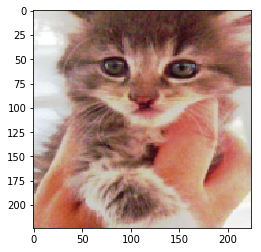

In [117]:
def denorm (inp,mean,std):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def get_rand_img_from_ds(ds,idx=None):
    rand_idx = np.random.randint(0,len(ds)) if idx is None else idx
    img,label = ds[rand_idx]
    return dc_denorm(img),label

dc_denorm = partial(denorm,mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
plt.imshow(get_rand_img_from_ds(trn_ds,3)[0])

### Look at augmented images

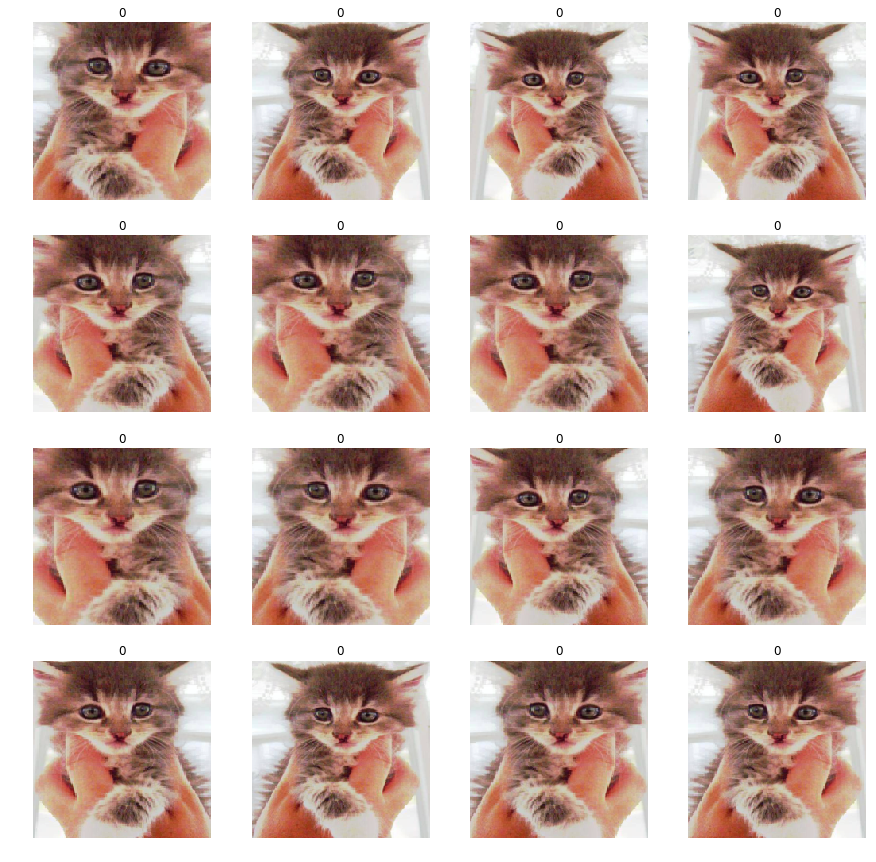

In [119]:
show_imgs_from_ds(trn_ds,partial(get_rand_img_from_ds,idx=3),figsize=(15,15))

### Dataloader

In [122]:
trn_dl = DataLoader(dataset=trn_ds,batch_size=32,shuffle=True,num_workers=6)
val_dl = DataLoader(dataset=val_ds,batch_size=32,shuffle=False,num_workers=6)

## ResNet Model

In [123]:
class MyResNET(nn.Module):
    def __init__(self):
        super().__init__()
        rn = resnet34(True)
        self.inp = nn.Sequential(rn.conv1,
                                 rn.bn1,
                                 rn.relu,
                                 rn.maxpool
                                )
        self.conv1 = rn.layer1
        self.conv2 = rn.layer2
        self.conv3 = rn.layer3
        self.conv4 = rn.layer4
        
    def forward(self,x):
        enc0 = self.inp(x)
        enc1 = self.conv1(enc0)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        return enc4

In [126]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.rn = MyResNET()
        self.trainable = False
        self.set_trainable(self.trainable)
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                        Flatten(),
                                        nn.Dropout(),
                                        nn.Linear(512,512),nn.BatchNorm1d(512),nn.ReLU(inplace=True),
                                        nn.Dropout(),
                                        nn.Linear(512,2)
                                       )

    def forward(self,x):
        enc = self.rn(x)
        return self.classifier(enc)
    
    def set_trainable(self,trainable=True):
        for param in self.rn.parameters():
            param.requires_grad = trainable

In [127]:
model,optimizer = get_model(MyNet,device)

In [128]:
fit(3,model,trn_dl,val_dl,device,optimizer,F.cross_entropy)

Epoch 0 || Train loss 0.17 || Val loss 0.06 || Accuracy 98.05
Epoch 1 || Train loss 0.13 || Val loss 0.05 || Accuracy 98.25
Epoch 2 || Train loss 0.13 || Val loss 0.06 || Accuracy 97.75


In [131]:
model.set_trainable(True)

## Training different layer groups with different learning rates - Discriminative learning

In [132]:
lr=1e-2
optimizer = optim.SGD([
    {'params':model.rn.parameters(),'lr':lr/100},
    {'params':model.classifier.parameters(),'lr':lr/10}
    
],lr=1e-4,momentum=0.9)

In [133]:
fit(10,model,trn_dl,val_dl,device,optimizer,F.cross_entropy)

Epoch 0 || Train loss 0.10 || Val loss 0.04 || Accuracy 98.4
Epoch 1 || Train loss 0.07 || Val loss 0.04 || Accuracy 98.7
Epoch 2 || Train loss 0.06 || Val loss 0.03 || Accuracy 98.7
Epoch 3 || Train loss 0.05 || Val loss 0.03 || Accuracy 98.6
Epoch 4 || Train loss 0.05 || Val loss 0.03 || Accuracy 98.75
Epoch 5 || Train loss 0.04 || Val loss 0.03 || Accuracy 98.75
Epoch 6 || Train loss 0.04 || Val loss 0.03 || Accuracy 98.95
Epoch 7 || Train loss 0.04 || Val loss 0.03 || Accuracy 98.75
Epoch 8 || Train loss 0.03 || Val loss 0.03 || Accuracy 98.75
Epoch 9 || Train loss 0.03 || Val loss 0.03 || Accuracy 98.85


### Adjusting learning rate with Cosine Annealing policy

In [155]:
optimizer = optim.SGD(model.parameters(),lr = 0.01)
schedule = lr_scheduler.CosineAnnealingLR(optimizer,10,0.0001)

In [163]:
lrs = []
for i,o in enumerate(range(100)):
    schedule.step()
    for param in optimizer.param_groups:
        lrs.append(param['lr'])
        
    


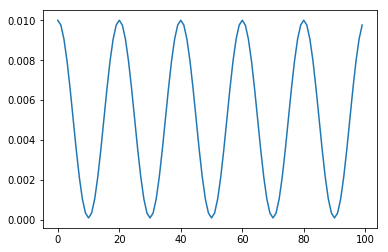

In [164]:
plt.plot(lrs)

### Training model with Cossine Annealing

In [165]:
def fit(epochs,model,train_dl,val_dl,device,optim,loss_fn,lr_scheduler=None):
    for epoch in range(epochs):
        if lr_scheduler:lr_scheduler.step()
        model.train()
        trn_loss = 0
        for batch_idx,(x,y) in enumerate(trn_dl):
            x,y = x.to(device),y.to(device)
            optim.zero_grad()
            outp = model(x)
            loss = loss_fn(outp,y)
            loss.backward()
            optim.step()
            trn_loss += loss.item()
        
        model.eval()
        val_loss = 0
        correct = 0
        for batch_idx,(x,y) in enumerate(val_dl):
            with torch.no_grad():
                x,y = x.to(device),y.to(device)
                outp = model(x)
                val_loss += loss_fn(outp,y,reduction='sum').item()
                pred = outp.max(dim=1,keepdim=True)[1]
                correct += pred.eq(y.view_as(pred)).sum().item()
        val_loss /= len(val_dl.dataset)

        print(f'Epoch {epoch} || Train loss {trn_loss/len(train_dl):.2f} || Val loss {val_loss:.2f} || Accuracy {100. * correct / len(val_dl.dataset)}')        
   

In [166]:
lr=1e-2
optimizer = optim.SGD([
    {'params':model.rn.parameters(),'lr':lr/100},
    {'params':model.classifier.parameters(),'lr':lr/10}
    
],lr=1e-4,momentum=0.9)
schedule = lr_scheduler.CosineAnnealingLR(optimizer,5)
fit(10,model,trn_dl,val_dl,device,optimizer,F.cross_entropy,schedule)

Epoch 0 || Train loss 0.03 || Val loss 0.03 || Accuracy 98.85
Epoch 1 || Train loss 0.03 || Val loss 0.03 || Accuracy 98.85
Epoch 2 || Train loss 0.03 || Val loss 0.03 || Accuracy 98.85
Epoch 3 || Train loss 0.03 || Val loss 0.03 || Accuracy 98.85
Epoch 4 || Train loss 0.03 || Val loss 0.03 || Accuracy 98.95
Epoch 5 || Train loss 0.03 || Val loss 0.03 || Accuracy 98.95
Epoch 6 || Train loss 0.03 || Val loss 0.03 || Accuracy 98.7
Epoch 7 || Train loss 0.03 || Val loss 0.03 || Accuracy 99.05
Epoch 8 || Train loss 0.03 || Val loss 0.03 || Accuracy 98.9
Epoch 9 || Train loss 0.03 || Val loss 0.03 || Accuracy 98.85


### Save model

In [167]:
torch.save(model.state_dict(),f'data/models/resnet34dc.pth')

### Load model

In [168]:
model.load_state_dict(torch.load(f'data/models/resnet34dc.pth',map_location=device))

### Integrate Attention in ResNet model and train with discriminative learning

In [178]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)
    
class ResNetWithBAM(nn.Module):
    def __init__(self):
        super().__init__()
        rn = resnet34(True)
        self.inp = nn.Sequential(rn.conv1,
                                 rn.bn1,
                                 rn.relu,
                                 rn.maxpool
                                )
        self.conv1 = rn.layer1
        self.conv2 = rn.layer2
        self.conv3 = rn.layer3
        self.conv4 = rn.layer4
        self.bam1,self.bam2,self.bam3,self.bam4 = BAM(64),BAM(128),BAM(256),BAM(512)
        
    def forward(self,x):
        enc0 = self.inp(x)
        enc1 = self.bam1(self.conv1(enc0))
        enc2 = self.bam2(self.conv2(enc1))
        enc3 = self.bam3(self.conv3(enc2))
        enc4 = self.bam4(self.conv4(enc3))
        return enc4
    
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.rn = ResNetWithBAM()
        self.trainable = False
        self.set_trainable(self.trainable)
        self.classifier = nn.Sequential(AdaptiveConcatPool2d(1),
                                        Flatten(),
                                        nn.Dropout(),
                                        nn.Linear(1024,512),nn.BatchNorm1d(512),nn.ReLU(inplace=True),
                                        nn.Dropout(),
                                        nn.Linear(512,2)
                                       )

    def forward(self,x):
        enc = self.rn(x)
        return self.classifier(enc)
    
    def set_trainable(self,trainable=True):
        for param in self.rn.parameters():
            param.requires_grad = trainable

In [179]:
model = MyNet().to(device)
model.set_trainable(True)
lrs=[1e-3,1e-2]
optimizer = optim.SGD([
    {'params':model.rn.parameters(),'lr':lrs[0]},
    {'params':model.classifier.parameters(),'lr':lrs[1]}
    
],lr=1e-2,momentum=0.9)

In [180]:
schedule = lr_scheduler.CosineAnnealingLR(optimizer,10)
fit(15,model,trn_dl,val_dl,device,optimizer,F.cross_entropy,schedule)

Epoch 0 || Train loss 0.08 || Val loss 0.04 || Accuracy 98.8
Epoch 1 || Train loss 0.04 || Val loss 0.03 || Accuracy 98.85
Epoch 2 || Train loss 0.03 || Val loss 0.03 || Accuracy 99.05
Epoch 3 || Train loss 0.02 || Val loss 0.03 || Accuracy 98.85
Epoch 4 || Train loss 0.02 || Val loss 0.03 || Accuracy 99.05
Epoch 5 || Train loss 0.02 || Val loss 0.03 || Accuracy 99.1
Epoch 6 || Train loss 0.01 || Val loss 0.03 || Accuracy 99.0
Epoch 7 || Train loss 0.01 || Val loss 0.03 || Accuracy 99.05
Epoch 8 || Train loss 0.01 || Val loss 0.03 || Accuracy 98.95
Epoch 9 || Train loss 0.01 || Val loss 0.03 || Accuracy 98.95
Epoch 10 || Train loss 0.01 || Val loss 0.03 || Accuracy 99.1
Epoch 11 || Train loss 0.01 || Val loss 0.03 || Accuracy 99.0
Epoch 12 || Train loss 0.01 || Val loss 0.03 || Accuracy 99.1
Epoch 13 || Train loss 0.01 || Val loss 0.03 || Accuracy 99.05
Epoch 14 || Train loss 0.01 || Val loss 0.03 || Accuracy 99.1


In [181]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)
    
class SENetResnet(nn.Module):
    def __init__(self):
        super().__init__()
        rn = resnet34(True)
        self.inp = nn.Sequential(rn.conv1,
                                 rn.bn1,
                                 rn.relu,
                                 rn.maxpool
                                )
        self.conv1 = rn.layer1
        self.conv2 = rn.layer2
        self.conv3 = rn.layer3
        self.conv4 = rn.layer4
        self.se1,self.se2,self.se3,self.se4 = SEModule(64),SEModule(128),SEModule(256),SEModule(512)
        
    def forward(self,x):
        enc0 = self.inp(x)
        enc1 = self.se1(self.conv1(enc0))
        enc2 = self.se2(self.conv2(enc1))
        enc3 = self.se3(self.conv3(enc2))
        enc4 = self.se4(self.conv4(enc3))
        return enc4
    
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.rn = SENetResnet()
        self.trainable = False
        self.set_trainable(self.trainable)
        self.classifier = nn.Sequential(AdaptiveConcatPool2d(1),
                                        Flatten(),
                                        nn.Dropout(),
                                        nn.Linear(1024,512),nn.BatchNorm1d(512),nn.ReLU(inplace=True),
                                        nn.Dropout(),
                                        nn.Linear(512,2)
                                       )

    def forward(self,x):
        enc = self.rn(x)
        return self.classifier(enc)
    
    def set_trainable(self,trainable=True):
        for param in self.rn.parameters():
            param.requires_grad = trainable

In [185]:
model = MyNet().to(device)
model.set_trainable(True)
lrs=[1e-3,1e-2]
optimizer = optim.SGD([
    {'params':model.rn.parameters(),'lr':lrs[0]},
    {'params':model.classifier.parameters(),'lr':lrs[1]}
    
],lr=1e-2,momentum=0.9)

In [183]:
schedule = lr_scheduler.CosineAnnealingLR(optimizer,10)
fit(15,model,trn_dl,val_dl,device,optimizer,F.cross_entropy,schedule)

Epoch 0 || Train loss 0.08 || Val loss 0.04 || Accuracy 98.4
Epoch 1 || Train loss 0.04 || Val loss 0.04 || Accuracy 98.5
Epoch 2 || Train loss 0.03 || Val loss 0.03 || Accuracy 98.8
Epoch 3 || Train loss 0.02 || Val loss 0.04 || Accuracy 98.75
Epoch 4 || Train loss 0.01 || Val loss 0.04 || Accuracy 99.1
Epoch 5 || Train loss 0.01 || Val loss 0.04 || Accuracy 98.95
Epoch 6 || Train loss 0.01 || Val loss 0.04 || Accuracy 98.9
Epoch 7 || Train loss 0.01 || Val loss 0.04 || Accuracy 98.95
Epoch 8 || Train loss 0.01 || Val loss 0.04 || Accuracy 99.05
Epoch 9 || Train loss 0.00 || Val loss 0.04 || Accuracy 98.95
Epoch 10 || Train loss 0.01 || Val loss 0.04 || Accuracy 98.95
Epoch 11 || Train loss 0.01 || Val loss 0.04 || Accuracy 98.9
Epoch 12 || Train loss 0.00 || Val loss 0.04 || Accuracy 99.0
Epoch 13 || Train loss 0.00 || Val loss 0.05 || Accuracy 98.65
Epoch 14 || Train loss 0.01 || Val loss 0.04 || Accuracy 99.0


In [186]:
schedule = lr_scheduler.CosineAnnealingLR(optimizer,10)
fit(15,model,trn_dl,val_dl,device,optimizer,F.cross_entropy)

Epoch 0 || Train loss 0.08 || Val loss 0.04 || Accuracy 98.65
Epoch 1 || Train loss 0.04 || Val loss 0.04 || Accuracy 98.5
Epoch 2 || Train loss 0.02 || Val loss 0.03 || Accuracy 98.95
Epoch 3 || Train loss 0.02 || Val loss 0.03 || Accuracy 98.9
Epoch 4 || Train loss 0.02 || Val loss 0.03 || Accuracy 98.9
Epoch 5 || Train loss 0.01 || Val loss 0.03 || Accuracy 99.0
Epoch 6 || Train loss 0.01 || Val loss 0.04 || Accuracy 99.05
Epoch 7 || Train loss 0.01 || Val loss 0.05 || Accuracy 98.9
Epoch 8 || Train loss 0.01 || Val loss 0.04 || Accuracy 99.05
Epoch 9 || Train loss 0.01 || Val loss 0.04 || Accuracy 98.95
Epoch 10 || Train loss 0.01 || Val loss 0.04 || Accuracy 99.1
Epoch 11 || Train loss 0.01 || Val loss 0.04 || Accuracy 99.05
Epoch 12 || Train loss 0.01 || Val loss 0.05 || Accuracy 99.05
Epoch 13 || Train loss 0.00 || Val loss 0.04 || Accuracy 99.15
Epoch 14 || Train loss 0.00 || Val loss 0.05 || Accuracy 99.1
